<a href="https://colab.research.google.com/github/andrea-gentilini/KeyEar/blob/main/Password_Detection_through_Sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔊 Audio-Based Sensitive Information Detection Using Convolutional Neural Networks

Author:

* Andrea Gentilini

In Google Colab, you can check the table of contents for your notebook by using the left-side window. **Resources** used for producing this notebook are listed at the end. **Let's get started!**

# Introduction

## 🎯 Premises and goals of this Project

The aim of this project is to provide a foundation for detecting sensitive information typed on a user's keyboard based on the sound emitted by the keys. To learn how to approach a real case problem, it has been decided to not use pre-existing datasets, but to create one from scratch. The data used, as well as their split into train/test/validate sets, are publicly available. Due to time constraints in dataset creation, the problem has been narrowed down to recognizing only 4-digit numeric pins. However, with more data, the task can easily be generalized to recognize any text string typed on a keyboard.



## 🛣 Approach used

The dataset consists of mono audio recordings, each labeled with four integers. Additionally, each audio track is categorized into one of the dataset types: train, validation, or test.
Each audio track undergoes the following pre-processing steps:
1. **Max-length**: The maximum length among the various audio tracks is calculated at a given sample rate. Even though we resample the audio tracks afterward, this resampling does not negatively affect either the accuracy of the model or the max-length calculation, which is solely used for padding purposes.
2. **Resampling**: Each track is resampled to a target sample rate using `torchaudio`. Resampling can be particularly useful for reducing computational complexity when handling large datasets.
3. **Mix down**: If a track is stereo, it is converted to mono. Although all tracks in the dataset are mono, this step is included for the sake of generalization.
4. **Right padding**: Zero padding is applied to each track to achieve the `max_length`. This is necessary as Convolutional Neural Networks (CNNs) require fixed-length input.
5. **Mel Spectrogram**: This is created to capture both time-domain and frequency-domain features. The mel scale is used to make the perception similar to human hearing.

The CNN is then trained on these mel spectrograms, which can be interpreted as images.

## 🗂️ Required File Organization (Directories) Overview

In the `sounds` directory, you can find all the recorded sounds (raw audio data).

The `information.csv` file contains all the information about the dataset, including labels for each audio track, and the dataset category they belong to (train, test, validate).

The `build_csv.ipynb` notebook is a utility used specifically to create the `information.csv` file properly.

`requirements.txt` is used for installing all the necessary libraries for this project. (You won't need it if you running this notebook in Google Colab).

`Password_Detection_through_Sound.ipynb` contains the complete project.

The project is designed to be run in Google Colab, with the data stored in Google Drive, where all files are organized in a folder named `ML-PROJECT`. Therefore, if you do not set up your directories this way, **you will need to modify the directory paths in the "Get started!" section**. If you do not use Colab, you may be unable to reproduce the audio using `IPython.display.Audio`.





# Get started!

To begin with the project, we need to set up the necessary file paths and import all required libraries. Follow the steps below to properly configure your environment.

## ⤵ Importing libraries




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


In [ ]:
# general
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import torch
import time

# audio
import torchaudio
from IPython.display import Audio
import librosa

# data
from sklearn.manifold import TSNE
import umap
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

## 📂 Directories

In [ ]:
# adjust the paths to your specific needs
PROJECT_DIR = '/content/drive/My Drive/ML-PROJECT'
INFO_FILE = '/content/drive/My Drive/ML-PROJECT/information.csv'
AUDIO_DIR = '/content/drive/My Drive/ML-PROJECT/sounds'

# Dataset

In this section, we'll explore the steps taken to build the dataset, the sources of the data, and the rationale behind the chosen methodology.

The dataset was crafted to capture the unique sound profile of typing on a MacBook Air 2023 M2 with a 15-inch screen. Here are the specifics of how the dataset was constructed:

## 🎙️ Recording Setup
- **Keyboard**: MacBook Air 2023 M2, 15-inch
- **Recording Device**: iPhone 11
- **Placement**: The iPhone was placed approximately 10 cm to the right of the MacBook, elevated about 5 cm from the floor. This positioning helps minimize sensitivity to table vibrations.

## ⚙️ Recording Process
- **Individual Recording**: Each key press was recorded individually to ensure clarity and consistency in the sound files.
- **Editing**: The recordings were edited using Audacity. Each audio file was trimmed at the beginning to (approximately) standardize the starting point of the sound.
- **Format and Sampling**: The sound was originally captured in mono format at a sample rate of 48000 Hz in .m4a format.
- **Conversion**: Using `ffmpeg`, a command-line tool, the audio files were converted to .wav format without altering the sample rate.
- **Storage**: All the processed audio files were stored in the `sounds` directory for structured access.



## 📝 Data Categorization and Metadata

The metadata for each recording is cataloged in an `information.csv` file, which is structured as follows:

| file_name | target | dataset_type |
|-----------|--------|--------------|
| "0.wav"   | "1234" | "train"      |
| "1.wav"   | "2345" | "train"      |
| ...       | ...    | ...          |

This CSV file contains the filename, the target typing sequence (label), and the dataset category (train, test, or validate), providing a clear and organized overview of the dataset composition.

By adhering to this detailed and structured approach to dataset construction, the project ensures high-quality and consistent audio data for training machine learning models aimed at detecting typed information based on keyboard sounds.

# Visualize Data

## ℹ️ Metadata

In [ ]:
# Count the total number of audio files in the dataset
# This includes files across all subsets: training, validation, and test.
len([file for file in os.listdir(AUDIO_DIR) if file.endswith('.wav')])

331

In [ ]:
# Load the CSV file as a string-only dataframe.
df = pd.read_csv(INFO_FILE, dtype=str)

# Display the first five rows to preview the data.
df.head()

,file_name,target,dataset_type
0,rec1-74.wav,1234,train
1,rec1-04.wav,2345,train
2,rec1-82.wav,3456,train
3,rec1-17.wav,4567,train
4,rec1-12.wav,5678,train


## 📼 Audio Recs

In [ ]:
# Load an audio file using torchaudio and store the audio data and sample rate
audio_tensor, sr = torchaudio.load(AUDIO_DIR + '/rec1-12.wav')

# Output the audio tensor shape, type, and sample rate
audio_tensor.shape, type(audio_tensor), sr             # audio_tensor has shape (channels, samples)

(torch.Size([1, 128928]), torch.Tensor, 48000)

In [ ]:
# let's listen to it
Audio(audio_tensor.numpy(), rate = sr)

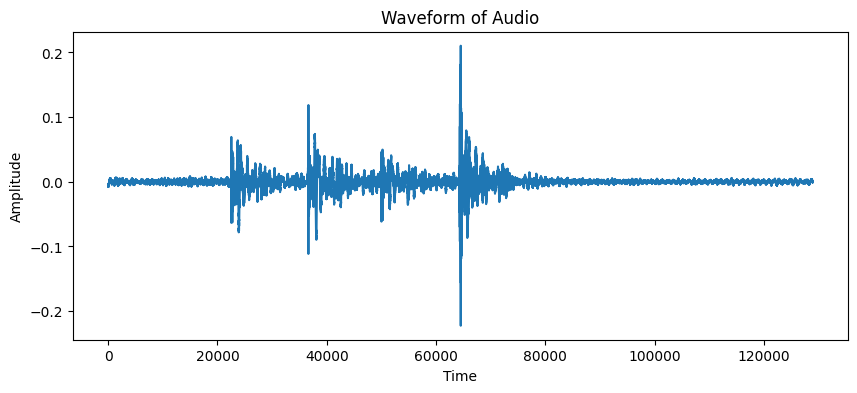

In [ ]:
# waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_tensor.t().numpy())
plt.title('Waveform of Audio')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

<ipython-input-13-5046d014772b>:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(spectrogram[0].numpy()), cmap='viridis', aspect='auto', origin='lower')


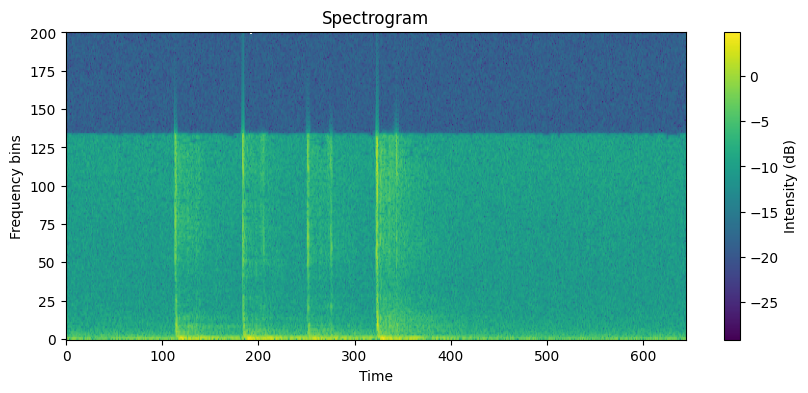

In [ ]:
# spectrogram
spectrogram_transform = torchaudio.transforms.Spectrogram()
spectrogram = spectrogram_transform(audio_tensor)

plt.figure(figsize=(10, 4))
plt.imshow(np.log(spectrogram[0].numpy()), cmap='viridis', aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency bins')
plt.colorbar(label='Intensity (dB)')
plt.show()

From the spectrogram above, we can observe that the high frequencies (approximately the top 30%) are mostly silent. While we could consider removing these frequencies during the audio preprocessing stage when creating the mel-spectrogram, it is possible that this range is actually important. The high frequencies are silent except for the exact moments when the keys are pressed, which might be crucial for the neural network to learn from. Therefore, we will leave these frequencies intact.

# Preprocessing Raw Data

## 🧩 PasswordDataset class

The `PasswordDataset` class preprocesses all the raw audio data and prepares them as inputs for the CNN, as explained in the `🛣 Approach used` section. It's designed to facilitate the handling and transformation of audio files into a consistent and uniform format that can be easily fed into a neural network. Below the implementation.


In [ ]:
# utils function
def calculate_max_length(audio_dir):
  """Calculates the maximum length of an audio file in a directory."""
  max_length = float('-inf')
  for aud in os.listdir(audio_dir):
    signal, sr = torchaudio.load(audio_dir + '/' + aud)
    max_length = max(max_length, signal.shape[1])
  return max_length

In [ ]:
# SETTING GLOBAL PARAMETERS
TARGET_SAMPLE_RATE = 48000
MAX_LENGTH = calculate_max_length(AUDIO_DIR)

MAX_LENGTH # in number of samples

156032

In [ ]:
class PasswordDataset(Dataset):
    def __init__(self, info_file, audio_dir, transformation, wanted_sr, max_length, dataset_type='train'):
      """
      Initializes the PasswordDataset by loading metadata and filtering it according to the specified dataset type.
      Args:
          info_file (str): Path to the CSV file containing metadata about audio files.
          audio_dir (str): Directory containing audio files.
          transformation (callable): A function or callable object that applies a transformation to each audio sample.
          wanted_sr (int): Desired sampling rate to which all audio files will be resampled.
          max_length (int): Maximum length to which audio samples will be padded or truncated.
          dataset_type (str): Specifies the subset of data to load ("train", "validation", "test").
      """
      super().__init__()
      self.info = pd.read_csv(info_file, dtype=str) # Load metadata from CSV
      self.info['dataset_type'] = self.info['dataset_type'].str.strip()
      self.info = self.info[self.info['dataset_type'] == dataset_type]  # Filter data by dataset type
      self.audio = audio_dir
      self.transformation = transformation
      self.wanted_sr = wanted_sr
      self.max_length = max_length

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.info)

    def __getitem__(self, index):
        """
        Fetches the transformed audio sample and its label based on the provided index.
        This method is called when accessing an element of the dataset using indexing.

        Args:
            index (int): Index of the audio sample to fetch.

        Returns:
            tuple: (transformed_signal, label), where transformed_signal is the tensor of audio data after processing,
                   and label is the integer tensor representation of the password.
        """
        audio_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index).strip()
        signal, sr = torchaudio.load(audio_path)         # Load the audio file, signal shape is (1, x)
        signal = self._resample_if_necessary(signal, sr) # Resample to uniform sampling rate
        signal = self._mix_down_if_necessary(signal)     # Convert to mono if necessary
        signal = self._right_pad_signal(signal)          # Pad the signal to the maximum length
        signal = self.transformation(signal)             # Apply the specified transformation
        label = torch.tensor([int(x) for x in label])
        return signal, label

    def _get_audio_sample_path(self, index):
        """Constructs the path to the audio file based on the dataset index."""
        file_name = self.info.iloc[index, 0]
        path = os.path.join(self.audio, file_name)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Audio file {path} not found.")
        return path

    def _get_audio_sample_label(self, index):
        """Retrieves the label for the audio sample based on the dataset index."""
        return self.info.iloc[index, 1]

    def _right_pad_signal(self, signal):
        """Pads the signal to the right with zeros to reach the maximum specified length."""
        pad_length = self.max_length - signal.shape[1]
        if pad_length > 0:
            padding = torch.zeros((1, pad_length))
            signal = torch.cat([signal, padding], dim=1)
        return signal

    def _resample_if_necessary(self, signal, sr):
        """Resamples the signal to the desired sampling rate if it differs from the current rate."""
        if sr != self.wanted_sr:
            new_sample_rate = self.wanted_sr
            resampled_signal = torchaudio.functional.resample(signal, sr, new_sample_rate)
            return resampled_signal
        return signal

    def _mix_down_if_necessary(self, signal):
        """Converts the signal to mono if it has more than one channel."""
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal


## 👻 Mel Spectrogram

The Mel Spectrogram is a powerful feature representation in the field of audio signal processing, particularly useful in speech and music analysis. It represents how the spectral density of frequencies in an audio signal varies over time, and does so in a way that aligns with human auditory perception.

$ $

**Foundation: Short-Time Fourier Transform (STFT)**

Before delving into the Mel Spectrogram, it's important to understand the Short-Time Fourier Transform (STFT), a fundamental technique in signal processing used to analyze the frequency content of signals over time, especially non-stationary signals whose frequency content changes.

**How STFT Works:**

1. **Windowing**:
   - The audio signal is divided into overlapping segments, or frames, using a window function (e.g., Hamming or Hann window) to minimize edge effects and isolate small portions of the signal for analysis.

2. **Fourier Transform**:
   - A Fourier Transform is applied to each windowed segment, converting it from the time domain to the frequency domain. This process results in a complex spectrum for each segment, capturing both amplitude (magnitude) and phase information.

3. **Combining Spectra**:
   - The spectra from all segments are combined to form a 2D representation: the STFT matrix, where each column corresponds to the spectrum of a single segment and each row represents a frequency component over time.

$ $

**STFT Representation:**

- **Magnitude**: Represents the amplitude of different frequency components in each time segment. Typically visualized as a spectrogram, where color intensity indicates amplitude.
- **Phase**: Captures the phase angle of the frequency components, which is essential for reconstructing the original signal.

$ $

**Transition to Mel Spectrogram:**

A Mel Spectrogram is essentially a Spectrogram where the frequency scale has been converted to the Mel Scale. This involves adapting the STFT to focus more on how humans perceive sound, which is more sensitive to changes at lower frequencies.

$ $

**Mathematical Expression of Spectrogram:**

The mathematical formula for a segment of a spectrogram can be expressed as follows:

$ S(t, f) = |FFT(x(t))|^2 $

$ $

**Mathematical Expression for Mel Frequency:**

The conversion from frequency to Mel scale is given by the formula:

$ m = 2595 \log_{10}(1 + \frac{f}{700}) $

$ $

**Mel Spectrogram Calculation**

The Mel Spectrogram $ M $ of a signal can be calculated using the following formula:

$ M = |FFT(x(t))| \cdot Mel\_filter\_bank $

$ $

**Main applications:**

Mel Spectrograms are extensively used in various audio processing applications, including:
- Speech recognition
- Music genre classification
- Emotion recognition from voice
- Sound event detection

Their ability to closely represent human auditory perception makes Mel Spectrograms especially valuable in systems designed to interact with or analyze human auditory activities.

--------------------
**OBSERVATION:**
Also the [cepstrum](https://it.wikipedia.org/wiki/Cepstrum) transformation has been analized, but was not giving good results.

In [ ]:
# Define the transformation for preparing our network's input
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=TARGET_SAMPLE_RATE,  # Expected sample rate of audio files. All audio will be resampled to this rate.
    n_fft=1024,                      # Size of FFT, determines the amount of data points used in each block for performing the Fourier Transform.
                                     # A higher value provides finer frequency resolution.
    hop_length=512,                  # The step size between successive frames of audio data.
                                     # Smaller values increase overlap and the number of frames generated.
    f_min=200,                       # The lowest frequency boundary included in the spectrogram.
    f_max=22050,                     # The highest frequency boundary included in the spectrogram.
    n_mels=16                        # Number of Mel bands to generate. Defines the "vertical" resolution of the output spectrogram.
)

## ▶️ Initialize the Training Dataset

In [ ]:
# Initialize the training dataset for password recognition using specified configurations.
psw_ds_train = PasswordDataset(
    INFO_FILE,             # Path to the CSV file containing metadata about the audio samples.
    AUDIO_DIR,             # Directory where audio files are stored.
    mel_spectrogram,       # Audio transformation to convert raw audio into a mel spectrogram.
    TARGET_SAMPLE_RATE,    # Desired sampling rate for all audio files to ensure consistency.
    MAX_LENGTH,            # Maximum length of audio samples; shorter samples will be padded and longer ones truncated.
    dataset_type="train",  # Specify that this dataset instance is for the training set.
)

## 📋 Let's Do Some Checks

Let's examine how the `PasswordDataset` class processes raw audio data to ensure everything functions correctly. Specifically, we'll verify if all Mel spectrograms have consistent shapes, as having fixed-size inputs is crucial for training our Convolutional Neural Network (CNN). It's important that each step in the data preparation pipeline maintains the integrity and uniformity of the data, which are essential for effective model training.


In [ ]:
# Print the total number of training examples in the training dataset
print(f"There are {len(psw_ds_train)} examples in the train dataset")

There are 158 examples in the train dataset


In [ ]:
# Check if the dataset target matches the expected value

element_index = 2  # Specify an index to test a specific dataset element

# Load metadata from the CSV file
df = pd.read_csv(INFO_FILE, dtype=str)

# Print the file name and target label for the selected element
print(f"element: {df.iloc[element_index]['file_name']}, target: {df.iloc[element_index]['target']}")

# Load the audio file's target using torchaudio from the dataset
from_dataset_target = psw_ds_train[element_index][1]
from_dataset_target  # Display the loaded target

element: rec1-82.wav, target: 3456


tensor([3, 4, 5, 6])

In [ ]:
# Verify that all Mel spectrogram dimensions are consistent across the dataset
# Despite varying data sample durations, we require fixed-size inputs for model training.
# Ensure all audio samples are uniform in size (have the same length).
ref_dims = psw_ds_train[0][0].shape  # Reference dimensions from the first sample
for i in range(len(psw_ds_train)):
    if psw_ds_train[i][0].shape != ref_dims:
        print(f"Dims don't match at index {i}. Dims: {(psw_ds_train[i][0].shape, ref_dims)}")

## 👀 Visualizing Mel-Spectrograms



In [ ]:
def plot_mel_spectrogram(mel_spectrogram, title="Mel Spectrogram", ylabel="Frequency (Hz)", aspect="auto", xmax=None):
    """Plots a Mel Spectrogram visualization.

    This function generates a visual representation of a Mel Spectrogram, often used to analyze the frequency content of audio signals over time. The plot is displayed with frequencies on the y-axis and time on the x-axis.

    Args:
        mel_spectrogram (tensor): The Mel Spectrogram to be visualized, expected to be a PyTorch tensor.
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
        aspect (str): Controls the aspect ratio of the plot. Default is 'auto', which adjusts dynamically.
        xmax (optional, int or float): Sets the maximum value on the x-axis, truncating the plot to this maximum if provided.
    """
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram.squeeze(0).numpy(), origin="lower", aspect=aspect)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Time (s)")
    if xmax:
        plt.xlim((0, xmax))
    plt.tight_layout()
    plt.show()

Shape of the Mel Spectrogram: torch.Size([1, 16, 305])
Label of the first sample: tensor([4, 5, 6, 7])


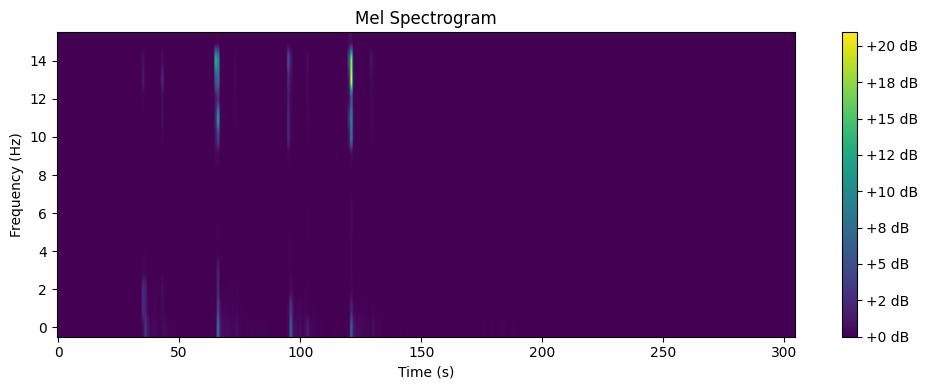

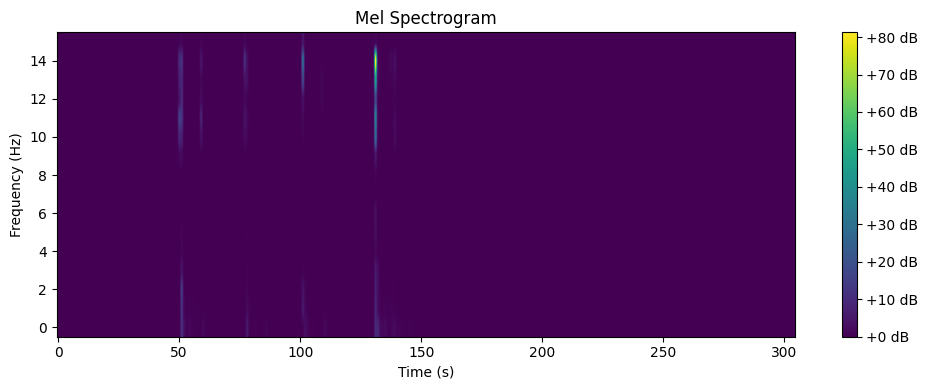

In [ ]:
# Fetch and display a sample from the dataset
signal, label = psw_ds_train[3]  # Retrieve a single sample and its label from the dataset at index 3
signal2, _ = psw_ds_train[10]    # Retrieve another sample from the dataset at index 10 for comparison
print(f"Shape of the Mel Spectrogram: {signal.shape}")  # Print the shape of the Mel Spectrogram for the first sample
print(f"Label of the first sample: {label}")  # Print the label associated with the first sample

# Visualize the Mel Spectrograms to compare their features
plot_mel_spectrogram(signal)  # Plot the Mel Spectrogram for the first sample
plot_mel_spectrogram(signal2)  # Plot the Mel Spectrogram for the second sample

**How many information are encoded in the spectrogram?**

Let's have a quick look.

In [ ]:
# listen to the first audio signal
signal, sr = torchaudio.load(AUDIO_DIR + '/' + pd.read_csv(INFO_FILE, dtype=str).iloc[0]['file_name'])

Audio(signal, rate=sr)

In [ ]:
# Reconstruct the signal from the mel-spectrogram
signal_processed = psw_ds_train[0][0]           # Retrieve the mel-spectrogram tensor from the dataset

mel_spectrogram_np = signal_processed.squeeze().numpy()  # Convert the PyTorch tensor to a NumPy array

# Correctly call the librosa mel function by specifying parameters as keywords
mel_basis = librosa.filters.mel(sr=TARGET_SAMPLE_RATE, n_fft=1024, n_mels=16)

# Calculate the pseudo-inverse of the mel filter matrix
inv_mel_basis = np.linalg.pinv(mel_basis)

# Apply the pseudo-inverse to obtain an approximate spectrogram
spec_from_mel = np.dot(inv_mel_basis, mel_spectrogram_np)

# Use the Griffin-Lim algorithm to reconstruct the phase and obtain the audio
reconstructed_audio = librosa.griffinlim(spec_from_mel, hop_length=512, n_iter=32)  # Increase n_iter to potentially improve quality

# Play the reconstructed audio
Audio(reconstructed_audio, rate=TARGET_SAMPLE_RATE)

As we can infer from the reconstruction, it is not entirely accurate. However, we are still able to distinguish the different keys and their frequencies. We can try to work with it!

(Additionally, we have not made extensive efforts to reconstruct the sound; there are far more precise methods available.)

# The Model

We utilize a Convolutional Neural Network (CNN) as our model because it is well-suited for processing image inputs (in this case, mel-spectrograms).



## 🗄️ Organizing data for the net

This section of the code handles the preparation of data for training the CNN.

In [ ]:
# Ensure that the input to the neural network is a PyTorch tensor
signal, label = psw_ds_train[7]  # Retrieve a sample and its label from the dataset
type(signal), type(label) # Verify the data types of both the signal and the label

(torch.Tensor, torch.Tensor)

In [ ]:
# number of training samples
len(psw_ds_train)

158

In [ ]:
# building the validation dataset
psw_ds_valid = PasswordDataset(
    INFO_FILE,
    AUDIO_DIR,
    mel_spectrogram,
    TARGET_SAMPLE_RATE,
    MAX_LENGTH,
    dataset_type = "valid",
)

In [ ]:
# Define Dataset subclass to facilitate batch training
class MultiOutputDataset(Dataset):
    def __init__(self, X, y1, y2, y3, y4): # they all should be tensors
        self.X = X
        self.y1 = y1
        self.y2 = y2
        self.y3 = y3
        self.y4 = y4

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y1[idx], self.y2[idx], self.y3[idx], self.y4[idx]

In [ ]:
# Stack all mel-spectrogram tensors from the training dataset into a single tensor
X_train_data = torch.stack([psw_ds_train[i][0] for i in range(len(psw_ds_train))])

# Create a list of tensors for each label index across all samples in the training dataset
X_train_labels = [torch.tensor([psw_ds_train[i][1][j] for i in range(len(psw_ds_train))]) for j in range(4)]

X_train_data.shape, len(X_train_labels), X_train_labels[0].shape

(torch.Size([158, 1, 16, 305]), 4, torch.Size([158]))

In [ ]:
# same for the valid data
X_valid_data = torch.stack([psw_ds_valid[i][0] for i in range(len(psw_ds_valid))])
X_valid_labels = [torch.tensor([psw_ds_valid[i][1][j] for i in range(len(psw_ds_valid))]) for j in range(4)]

X_valid_data.shape, len(X_valid_labels), X_valid_labels[0].shape

(torch.Size([95, 1, 16, 305]), 4, torch.Size([95]))

In [ ]:
dataset_training = MultiOutputDataset(X_train_data, *X_train_labels)
dataset_validation = MultiOutputDataset(X_valid_data, *X_valid_labels)

In [ ]:
dataset_training[0] # still tensors

(tensor([[[0.0028, 0.0099, 0.0093,  ..., 0.0000, 0.0000, 0.0000],
          [0.0057, 0.0087, 0.0054,  ..., 0.0000, 0.0000, 0.0000],
          [0.0038, 0.0076, 0.0044,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0099, 0.0100, 0.0107,  ..., 0.0000, 0.0000, 0.0000],
          [0.0070, 0.0118, 0.0102,  ..., 0.0000, 0.0000, 0.0000],
          [0.0005, 0.0011, 0.0006,  ..., 0.0000, 0.0000, 0.0000]]]),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(4))

In [ ]:
# Create DataLoaders for training and test set, for batch training and evaluation
train_loader = DataLoader(dataset_training, batch_size=8, shuffle=True, num_workers = 2, pin_memory = True)
valid_loader = DataLoader(dataset_validation, batch_size=8, shuffle=False, num_workers = 2, pin_memory = True)

In [ ]:
# DataLoader processes data batch by batch
for data, first_ch_label, second_ch_label, third_ch_label, fourth_ch_label in train_loader:
  print(data.shape)
  print(first_ch_label.shape)
  print(second_ch_label.shape)
  print(third_ch_label.shape)
  print(fourth_ch_label.shape)
  break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([8, 1, 16, 305])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])


In [ ]:
# setting the device to do training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 🏛️ Architecture

$ $

**Convolutional Processing Layers**

The architecture initiates with a series of convolutional layers that are pivotal for their capacity to extract intricate feature representations from input spectrograms. These layers apply a sequence of learned filters to the input, producing feature maps that encapsulate localized patterns across the input spectrum.

- **Initial Layer Configuration**: The primary convolutional layer ingests input characterized by `num_channels`, reflecting the multi-faceted nature of the acoustic data. It outputs 32 feature maps using a kernel of size 3x3. This configuration is designed to preserve spatial dimensions while facilitating the detection of fine-grained details.
- **Non-Linearity and Pooling Strategy**: Each convolutional operation is followed by a ReLU activation function, introducing necessary non-linear capabilities to the network, thereby enabling it to learn complex patterns. A strategically conservative max pooling follows, aimed at reducing output dimensions subtly, thereby retaining critical spatial information which is imperative for sound analysis.
- **Subsequent Layer Configuration**: The depth is increased to 64 feature maps in the subsequent layer to allow the network to construct a more abstract representation of the input features, further processed by ReLU activation and conservative pooling.
- **Stride and Kernel Size**: Employing a smaller stride, such as 1, enhances the model’s ability to maintain spatial resolution. A stride of 1 means that the convolutional filters move across the input data one pixel at a time, allowing for a finer and more detailed mapping of the input features. In addition, utilizing small kernels, such as 3x3, in convolutional layers is an effective strategy for capturing fine details in input data.
-**Conservative pooling**: Given that key information may be contained within fine lines, using conservative pooling strategies such as `MaxPool2d(2, stride=1)` can be advantageous.


Post convolutional processing, the outputs are flattened. This transformation is critical as it transmutes the multi-dimensional feature maps into a vector format, suitable for subsequent fully connected processing. The `flattened_size` is computed based on the output dimensions expected from the final pooling layers.

$ $

**Fully Connected and Output Layers**

- **Modular Construction of Dense Layers**: The network dynamically constructs several fully connected layers based on predefined `hidden_sizes`. Each layer sequentially transforms the data into increasingly abstracted and relevant feature spaces, which is fundamental for the discrimination tasks at hand.
- **Multi-Output Configuration**: The architecture incorporates multiple distinct output layers, each tailored to classify different attributes of the input. This design is crucial for multi-character prediction tasks where each output layer is specialized to focus on a particular subset of the class space.

$ $

**Why this architecture?**
1. **Pattern Recognition**: Given the convolutional layers' proficiency in capturing both spatial and temporal dependencies, they are well-suited for handling spectrogram data where such patterns directly correlate to distinct keyboard strokes.
2. **Flexibility in Feature Transformation**: The adaptable configuration of the fully connected layers permits the model to fine-tune its processing capabilities based on the data's complexity and heterogeneity, characteristic of acoustic signals.
3. **Dedicated Multi-Output Handling**: The explicit design to accommodate multiple outputs aligns with the objective of decoding sequences of characters from single acoustic inputs.
4. **Information Preservation Through the Network**: The use of conservative pooling and the progressive augmentation of feature map depth throughout the network play a pivotal role in preserving essential information, thereby enhancing the model's overall predictive accuracy.



In [ ]:
class ModelMultiCNN(nn.Module):
    def __init__(self, num_channels, num_mel_filters, num_time_frames, hidden_sizes):
        super(ModelMultiCNN, self).__init__()

        # Define the convolutional layers sequence with padding to preserve dimensions and conservative pooling
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1),  # Slight dimension reduction without significant loss of data
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)
        )

        # Calculate the flattened output size for fully connected layer input
        self.flattened_size = 64 * 14 * 303

        # Set up fully connected layers to condense extracted features into predictions
        self.fcs = nn.ModuleList()
        in_size = self.flattened_size
        for next_size in hidden_sizes:
            self.fcs.append(nn.Linear(in_size, next_size))
            in_size = next_size

        # Multi-output layer setup for individual digit predictions
        self.digit_layers = nn.ModuleList([nn.Linear(in_size, 10) for _ in range(4)])

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.flattened_size)  # Flatten the convolution output
        for fc in self.fcs:
            x = F.relu(fc(x))
        outputs = [F.softmax(digit(x), dim=1) for digit in self.digit_layers]
        return outputs  # Returns a list of softmax probabilities for each output digit

In [ ]:
num_channels = X_train_data.shape[1]      # int
num_mel_filters = X_train_data.shape[2]   # int
num_time_frames = X_train_data.shape[3]   # int
hidden_sizes = [128, 64, 32]
model = ModelMultiCNN(num_channels=num_channels, num_mel_filters=num_mel_filters, num_time_frames=num_time_frames, hidden_sizes=hidden_sizes).to(device)

## 🏋🏻‍♂️ Training

mettere empji di uno che si allena

Epoch 1/20 completed. Train Loss: 9.156, Validation Loss: 9.249
Epoch 2/20 completed. Train Loss: 8.945, Validation Loss: 9.298
Epoch 3/20 completed. Train Loss: 8.798, Validation Loss: 9.267
Epoch 4/20 completed. Train Loss: 8.676, Validation Loss: 9.246
Epoch 5/20 completed. Train Loss: 8.511, Validation Loss: 9.242
Epoch 6/20 completed. Train Loss: 8.412, Validation Loss: 9.293
Epoch 7/20 completed. Train Loss: 8.489, Validation Loss: 9.264
Epoch 8/20 completed. Train Loss: 8.384, Validation Loss: 9.288
Epoch 9/20 completed. Train Loss: 8.349, Validation Loss: 9.250
Epoch 10/20 completed. Train Loss: 8.306, Validation Loss: 9.295
Epoch 11/20 completed. Train Loss: 8.247, Validation Loss: 9.243
Epoch 12/20 completed. Train Loss: 8.248, Validation Loss: 9.310
Epoch 13/20 completed. Train Loss: 8.159, Validation Loss: 9.292
Epoch 14/20 completed. Train Loss: 8.150, Validation Loss: 9.268
Epoch 15/20 completed. Train Loss: 8.047, Validation Loss: 9.223
Epoch 16/20 completed. Train Loss:

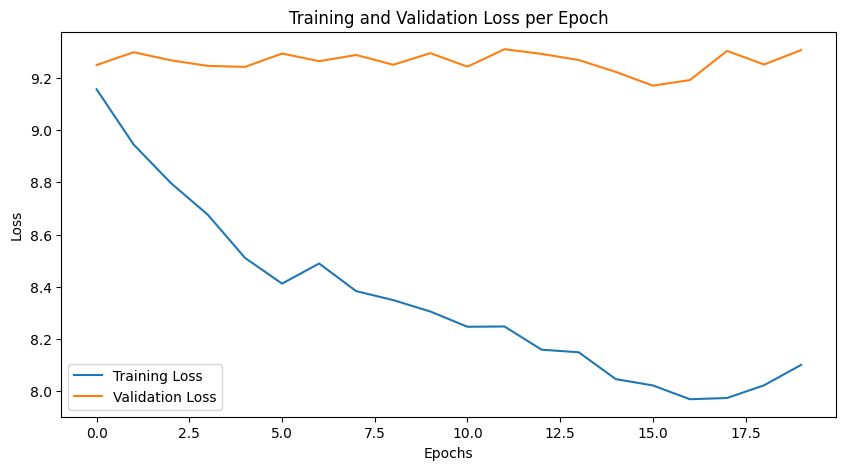

In [ ]:
# before doing another training re-initialize the model

torch.cuda.empty_cache()

num_epochs = 20
time_start = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss_total = 0

    for data, target1, target2, target3, target4 in train_loader:
        data = data.to(device)
        targets = [target1.to(device), target2.to(device), target3.to(device), target4.to(device)]
        optimizer.zero_grad()

        outputs = model(data)
        train_loss = sum(criterion(output, target) for output, target in zip(outputs, targets))

        train_loss.backward()
        optimizer.step()
        train_loss_total += train_loss.item() * data.size(0)

    train_loss_avg = train_loss_total / len(train_loader.dataset)

    model.eval()
    valid_loss_total = 0
    with torch.no_grad():
        for data, target1, target2, target3, target4 in valid_loader:
            data = data.to(device)
            targets = [target1.to(device), target2.to(device), target3.to(device), target4.to(device)]

            outputs = model(data)
            valid_loss = sum(criterion(output, target) for output, target in zip(outputs, targets))
            valid_loss_total += valid_loss.item() * data.size(0)

    valid_loss_avg = valid_loss_total / len(valid_loader.dataset)

    train_losses.append(train_loss_avg)
    valid_losses.append(valid_loss_avg)

    print(f'Epoch {epoch + 1}/{num_epochs} completed. Train Loss: {train_loss_avg:.3f}, Validation Loss: {valid_loss_avg:.3f}')

print(f'Time taken to complete {num_epochs} epochs: {(time.time() - time_start) / 60:.2f} minutes')

# Plotting the losses after training
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# model summary
summary(model, input_size=(num_channels, num_mel_filters, num_time_frames))  # Adatta l'input_size alle dimensioni di input reali

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 16, 305]             320
              ReLU-2          [-1, 32, 16, 305]               0
         MaxPool2d-3          [-1, 32, 15, 304]               0
            Conv2d-4          [-1, 64, 15, 304]          18,496
              ReLU-5          [-1, 64, 15, 304]               0
         MaxPool2d-6          [-1, 64, 14, 303]               0
            Linear-7                  [-1, 128]      34,750,592
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 32]           2,080
           Linear-10                   [-1, 10]             330
           Linear-11                   [-1, 10]             330
           Linear-12                   [-1, 10]             330
           Linear-13                   [-1, 10]             330
Total params: 34,781,064
Trainable para

In [ ]:
# save the last model
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Example of using the model
example_input = X_train_data[2] # mel-spectro
example_input_dev = example_input.to(device)
outputs = model(example_input_dev)
print(outputs)
print('-----------------------------------------------------------------------')

# prediction
predicted_digits = [torch.argmax(output, dim=1).item() for output in outputs]
print("Predicted PIN:", predicted_digits)

[tensor([[4.6679e-03, 9.5844e-01, 8.5723e-06, 9.4149e-07, 8.7170e-11, 2.4547e-08,
         3.6887e-02, 2.4679e-16, 1.0062e-08, 1.7749e-12]],
       grad_fn=<SoftmaxBackward0>), tensor([[3.7331e-16, 5.4248e-13, 3.9376e-14, 5.2263e-10, 1.0610e-09, 5.8221e-06,
         2.6931e-05, 9.9997e-01, 4.2132e-13, 1.2450e-06]],
       grad_fn=<SoftmaxBackward0>), tensor([[2.5602e-10, 1.2292e-10, 2.0450e-14, 2.9303e-11, 2.7313e-10, 9.9860e-01,
         1.2835e-03, 6.0756e-06, 9.4190e-05, 1.3703e-05]],
       grad_fn=<SoftmaxBackward0>), tensor([[3.4760e-15, 2.3119e-14, 6.9453e-09, 2.9888e-07, 2.6307e-11, 1.6570e-10,
         9.9999e-01, 5.2904e-06, 8.1418e-07, 8.3501e-07]],
       grad_fn=<SoftmaxBackward0>)]
-----------------------------------------------------------------------
Predicted PIN: [1, 7, 5, 6]


## 🕵️ Test

In [ ]:
# prepare the data as has been done for train/validation

psw_ds_test = PasswordDataset(
    INFO_FILE,
    AUDIO_DIR,
    mel_spectrogram,
    TARGET_SAMPLE_RATE,
    MAX_LENGTH,
    dataset_type = "test",
)

X_test_data = torch.stack([psw_ds_test[i][0] for i in range(len(psw_ds_test))])
X_test_labels = [torch.tensor([psw_ds_test[i][1][j] for i in range(len(psw_ds_test))]) for j in range(4)]

dataset_test = MultiOutputDataset(X_test_data, *X_test_labels)

test_loader = DataLoader(dataset=dataset_test, batch_size=8, shuffle=False, num_workers = 2, pin_memory = True)

In [ ]:
"""
USE THIS CODE IF YOU WANT TO USE THE SAVED VERSION OF THE MODEL AVAILABLE IN THE REPO
# load back the model
model = ModelMultiCNN(num_channels=num_channels, num_mel_filters=num_mel_filters, num_time_frames=num_time_frames, hidden_sizes=hidden_sizes).to(device)
state_dict = torch.load("model.pth")
model.load_state_dict(state_dict)
"""
pass

In [ ]:
def calculate_accuracy(outputs, targets):
    # Calculate accuracy for multi-output model
    total_correct_digits = 0
    total_elements = 0
    complete_pin_correct = 0

    batch_size = targets[0].size(0)
    correct_pins_per_batch = torch.zeros(batch_size, device=targets[0].device)

    for output, target in zip(outputs, targets):
        preds = torch.argmax(output, dim=1)
        correct_digits = (preds == target)
        total_correct_digits += correct_digits.sum().item()
        total_elements += target.nelement()

        correct_pins_per_batch += correct_digits.int()

    # A PIN is considered correct only if all four digits are correct
    complete_pin_correct = (correct_pins_per_batch == len(targets)).sum().item()

    digit_accuracy = total_correct_digits / total_elements
    pin_accuracy = complete_pin_correct / batch_size

    return digit_accuracy, pin_accuracy

model.eval()
test_loss_total = 0
test_digit_accuracy_total = 0
test_pin_accuracy_total = 0

with torch.no_grad():
    for data, target1, target2, target3, target4 in test_loader:
        data = data.to(device)
        targets = [target1.to(device), target2.to(device), target3.to(device), target4.to(device)]

        outputs = model(data)
        test_loss = sum(criterion(output, target) for output, target in zip(outputs, targets))
        test_loss_total += test_loss.item() * data.size(0)

        digit_accuracy, pin_accuracy = calculate_accuracy(outputs, targets)
        test_digit_accuracy_total += digit_accuracy * data.size(0)
        test_pin_accuracy_total += pin_accuracy * data.size(0)

test_loss_avg = test_loss_total / len(test_loader.dataset)
test_digit_accuracy_avg = test_digit_accuracy_total / len(test_loader.dataset)
test_pin_accuracy_avg = test_pin_accuracy_total / len(test_loader.dataset)

print(f'Test Loss: {test_loss_avg:.3f}, Digit Accuracy: {test_digit_accuracy_avg:.3f}, Complete PIN Accuracy: {test_pin_accuracy_avg:.3f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Test Loss: 9.417, Digit Accuracy: 0.109, Complete PIN Accuracy: 0.000


# ⚖️ Improvements and Conclusions

The model is really bad. We can see that he learns (in fact, the training loss decreases), but he does not generalize (a.k.a. overfitting).

This is probably because the training dataset contains only around 158 samples. But let's try to dive deeper into the question.

Let's try to visualize our data by doing t-SNE

In [ ]:
# Data Preparation
num_samples = len(psw_ds_train)
data = np.zeros((num_samples, num_channels * num_mel_filters * num_time_frames))  # Dimensions [number of spectrograms, len(flattened_spectrogram)]
labels = []

for i in range(num_samples):
    spectrogram = psw_ds_train[i][0]  # Spectrogram
    label_tensor = psw_ds_train[i][1]  # Label as a PyTorch tensor
    data[i, :] = spectrogram.flatten().numpy()
    label_str = ''.join(str(x) for x in label_tensor.tolist())  # Convert the label tensor to a string
    labels.append(label_str)

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
data_transformed = tsne.fit_transform(data)

# Creating DataFrame for Plotly
import pandas as pd
df = pd.DataFrame(data_transformed, columns=['Dimension 1', 'Dimension 2'])
df['Label'] = labels

# Interactive Plot with Plotly
fig = px.scatter(df, x='Dimension 1', y='Dimension 2', color='Label', hover_data=['Label'])
fig.update_layout(title='2D t-SNE Visualization of Spectrograms', xaxis_title='t-SNE Dimension 1', yaxis_title='t-SNE Dimension 2')
fig.show()

No evident patterns appear. However, if we observe that spectrograms encoding the same string of characters are distantly spaced in the visualization, it indicates that the t-SNE is not effectively capturing the relationships between similar targets.

In [ ]:
# Labels to visualize
target_labels = ["1234"]  # Add labels as needed

# Data preparation
num_samples = len(psw_ds_train)
data = []
labels = []

for i in range(num_samples):
    spectrogram = psw_ds_train[i][0]  # Spectrogram
    label_tensor = psw_ds_train[i][1]  # Label as a PyTorch tensor
    label_str = ''.join(str(x) for x in label_tensor.tolist())  # Convert tensor to string

    if label_str in target_labels:
        data.append(spectrogram.flatten().numpy())
        labels.append(label_str)

# Only display if data is available
if data:
    data = np.array(data)  # Convert list to NumPy array

    # Adjust t-SNE perplexity based on the number of samples
    perplexity_value = min(5, len(data) - 1) if len(data) > 1 else 1

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    data_transformed = tsne.fit_transform(data)

    # Create DataFrame for Plotly
    df = pd.DataFrame(data_transformed, columns=['Dimension 1', 'Dimension 2'])
    df['Label'] = labels

    # Interactive Plotly chart
    fig = px.scatter(df, x='Dimension 1', y='Dimension 2', color='Label', hover_data=['Label'])
    fig.update_layout(title='2D t-SNE Visualization of Spectrograms for Selected Labels',
                      xaxis_title='t-SNE Dimension 1', yaxis_title='t-SNE Dimension 2')
    fig.show()
else:
    print(f"No data found for the specified labels")

It appears that t-SNE is failing to capture any significant structure, regardless of the perplexity setting chosen. Despite encoding the sequence "1234," all spectrograms are dispersed in the t-SNE space. This dispersion prompts a review of what information mel spectrograms might contain:

- **Frequency Information**: If the spectrograms contained distinct frequency information, given our setup allows for distinguishable frequencies, one would expect all points representing the same sequence to cluster closely. However, this is not observed.
- **Timing Information**: If the spectrograms captured information about the time intervals between keystrokes, one might expect at least some of these points to cluster, especially since the dataset was created by a single person. It is reasonable to assume that the sequence "1234" would be typed in a similar manner on multiple occasions, yet no such pattern emerges.
- **Combination of Both**: The absence of any discernible pattern, even when considering both frequency and timing information, is puzzling.

Even UMAP (as shown below), known for its efficacy in handling high-dimensional data and maintaining both local and global structures, fails to reveal any meaningful patterns.

**Why?**

It may be that the variability in the spectrograms due to differences in duration, intensity, and sound quality, even for the same numerical sequence (target), might be complicating the ability of dimensionality reduction algorithms to capture essential similarities. Furthermore, spectrograms are high-dimensional data, and t-SNE may struggle to effectively reduce these dimensions while preserving local structures in complex data.



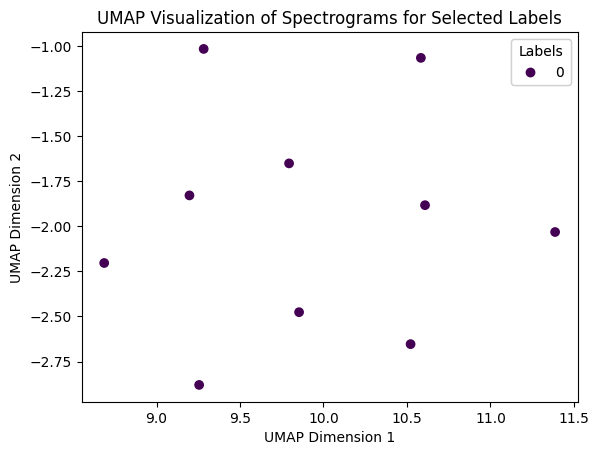

In [ ]:
# UMAP
target_labels = ["1234"]  # Add labels as needed

# Data preparation
num_samples = len(psw_ds_train)
data = []
labels = []

for i in range(num_samples):
    spectrogram = psw_ds_train[i][0]  # Spectrogram
    label_tensor = psw_ds_train[i][1]  # Label as a PyTorch tensor
    label_str = ''.join(str(x) for x in label_tensor.tolist())  # Convert tensor to string

    if label_str in target_labels:
        data.append(spectrogram.flatten().numpy())
        labels.append(label_str)

# Only display if data is available
if data:
    data = np.array(data)  # Convert list to NumPy array

    # Apply UMAP
    n_neighbors = min(10, data.shape[0] - 1)
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_jobs=-1)
    data_transformed = reducer.fit_transform(data)

    # Create DataFrame for plotting
    df = pd.DataFrame(data_transformed, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    df['Label'] = labels

    # Plot using matplotlib
    fig, ax = plt.subplots()
    scatter = ax.scatter(df['UMAP Dimension 1'], df['UMAP Dimension 2'], c=pd.Categorical(df['Label']).codes)
    legend = ax.legend(*scatter.legend_elements(), title="Labels")
    ax.add_artist(legend)
    plt.title('UMAP Visualization of Spectrograms for Selected Labels')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()
else:
    print(f"No data found for the specified labels")


Even though manifold learning algorithms have not been effective in this specific case, I believe that this task could still be resolved with a larger dataset. Indeed, the decreasing training loss indicates that **the model is capable of learning something useful for our purpose**. Furthermore, we have evidence that the mel-spectrogram is capturing relevant audio information, as we have (mostly) successfully reconstructed sound from the mel spectrogram. This suggests that with more data, the model might generalize better and potentially reveal clearer patterns, even if current dimensionality reduction techniques are failing to do so.

$ $

**Strategies for Improving Model Performance:**

- **Transfer Learning**: We could try to utilize a pre-trained model trained on a similar task (audio classification), and fine-tune it on our dataset. This approach could reduce the need for a large dataset.

- **Data Augmentation**: Although it is not straightforward how to perform it, since the information is encoded both in the frequency of the sound emitted by the key and in the time between different key presses.

- **Experimenting with Raw Data**: We could use the raw data (the waveform) instead of the mel spectrogram and see the result. This might lead to different. In fact, even though the waveform does not capture information about the frequency sound, it might reveal different aspects of the audio data that mel spectrograms do not capture.

- **Preventing Overfitting**: If, even after adding more data, the validation loss remains stable while the training loss continues to decrease (as above), we should consider implementing techniques to prevent overfitting. This might include adding an L2 penalty or reducing the complexity of the model.

- **Early Stopping**: Monitor the validation loss and stop training when it begins to degrade, even if it’s before you’ve completed all planned epochs. This prevents overfitting by not allowing the model to train excessively on the training data.

# 📚 References

- **Audio Preprocessing**:
  * **PyTorch**:
    * https://pytorch.org/audio/stable/generated/torchaudio.transforms.MelSpectrogram.html#torchaudio.transforms.MelSpectrogram
    * https://pytorch.org/audio/stable/index.html
  
  * **Valerio Velardo - the sound of AI**:
    * https://www.youtube.com/watch?v=gp2wZqDoJ1Y&list=PL-wATfeyAMNoirN4idjev6aRu8ISZYVWm
    * https://github.com/musikalkemist/pytorchforaudio
    * https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0
    * https://github.com/musikalkemist/AudioSignalProcessingForML

  * **Various**:
    * https://www.youtube.com/watch?v=Isa-qo_vXnw
    * https://www.youtube.com/watch?v=hF72sY70_IQ
    * https://it.wikipedia.org/wiki/Cepstrum
    * https://librosa.org/doc/latest/index.html
  
$ $

- **Model's architecture**:
  * **Articles**:
    * https://arxiv.org/abs/1312.6082
    * https://arxiv.org/pdf/1610.00087

  * **Blogs**:
    * https://towardsdatascience.com/converting-a-deep-learning-model-with-multiple-outputs-from-pytorch-to-tensorflow-a2d27a8e44f4
    * https://medium.com/jdsc-tech-blog/multioutput-cnn-in-pytorch-c5f702d4915f
    * https://www.kaggle.com/code/megaslav/multiple-outputs-prediction-with-pytorch/notebook
  
  * **Forums:**
    * https://stackoverflow.com/questions/55128814/how-can-i-make-a-neural-network-that-has-multiple-outputs-using-pytorch
    * https://discuss.pytorch.org/t/a-model-with-multiple-outputs/10440/10
  